In [8]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas import *
from numpy.linalg import inv
import pylab
import statistics
import time

In [2]:
def printI(a):
    for row in range(len(a)):
        for col in range (len(a[row])):
            print("{:1.0f}".format(a[row][col]), end = " ")
        print()

def printF(a):
    for row in range(len(a)):
        for col in range (len(a[row])):
            print("{:3.4f}".format(a[row][col]), end = " ")
        print()

In [3]:
States = np.loadtxt('StateData_L2.dat')
nC=2; nN=2; TotalStates=7
M = np.zeros(shape=(nC,nN))
I = np.zeros(shape=(TotalStates,nC+nN,nC+nN))

In [ ]:
#Below I will again try for N different Yield sets but this time I will chose Yields uniformly Between [X,1-X]
# with X = 0.45 (so that I get StdDev(Yc/Yn))
#For each Yield I will get the Multistable Count and store the Determinant of the last state
start_time = time.time()
X = 0.45
SeedForYieldRange=1000
Confidence = np.zeros(shape=(SeedForYieldRange,2*nC*nN + 3))
Deter = np.zeros(shape=(TotalStates))
for SeedForYield in range(SeedForYieldRange):
    #print("For", SeedForYield)
    I = np.zeros(shape=(TotalStates,nC+nN,nC+nN))
    
    np.random.seed(SeedForYield)
    YieldC = np.random.uniform(X,1-X,nC*nN)
    YieldN = np.random.uniform(X,1-X,nC*nN)
    
    Ratio = YieldC/YieldN
    
    #print("YieldC", YieldC, "\nYieldN", YieldN, "\nRatio", Ratio, "StdDev(Ratio)", statistics.stdev(Ratio))
    ###############################
    Confidence[SeedForYield][0:nC*nN] = YieldC
    Confidence[SeedForYield][nC*nN:2*nC*nN] = YieldN
    Confidence[SeedForYield][2*nC*nN] = statistics.stdev(Ratio)
    ##################################################
    for S in range(TotalStates):
        #print(S,States[S,:])
        for i in range(0,nC,1):
            for j in range(0,nN,1):
                M[i,j]=States[S,(i*nC)+j]
        #printI(M)
    
        IDC=[]
        IDN=[]
        k=0
        for i in range(0,nC,1):
            for j in range(0,nN,1):
                if(M[i,j] != 0):
                    IDC.append(i)
                    IDN.append(j)
                    k+=1
    
        Y = np.zeros(shape=(nC+nN,nC+nN))
        for i in range(0,len(IDC), 1):
            Y[IDC[i],i] = 1/YieldC[nC*IDC[i] + IDN[i]]
            Y[nN+IDN[i],i] = 1/YieldN[nC*IDC[i] + IDN[i]]
        
        w = len(IDC)
        while (w < nC+nN):
            for i in range(0,nC,1):
                for j in range(0,nN,1):
                    if(M[i,j] == -1):
                        break
                if(M[i][j] != -1):
                    Y[i,w] = 1.0
                    w += 1
            
            for j in range(0,nN,1):
                for i in range(0,nC,1):
                    if(M[i,j] == 1):
                        break
                if(M[i][j] != 1):
                    Y[nC+j,w] = 1.0
                    w += 1
            
        #print("Yield is")
        #printF(Y)
        
        I[S,:,:]=inv(Y)

        Deter[S] = np.linalg.det(I[S,:,:])
        Deter[S] = 1/Deter[S]
        #print("determinant of", S+1, "=", Deter[S])

        
        
        
        #print("Inverse of", S+1, "is")
        #printF(I[S,:,:])
    ##################################################
    Confidence[SeedForYield][2*nC*nN + 1] = Deter[6]
    StatePhase1 = 0; StatePhase3 = 0; StatePhase5 = 0
    L1=[]
    L3=[]
    L5=[]
    
    SeedForPhiPointsRange=100000
    for PhiPoint in range(SeedForPhiPointsRange*SeedForYield, 
                          SeedForPhiPointsRange*(SeedForYield+1), 1):#loop for chosing different Phi-points
        #print("PhiPoint:", PhiPoint)
        np.random.seed(PhiPoint)#This contains the seed
        Phi = np.random.uniform(10,1000,nC+nN)
        #print("Phi:", Phi)
        NoOfStates = 0; q = [0]*5
        for S in range(TotalStates):
            X = np.matmul(I[S,], Phi)
            for i in range(nC+nN):
                if (X[i] < 0.0):
                    break
            if (X[i] > 0.0):
                #print(S+1)
                NoOfStates += 1
                q[NoOfStates] = S +1
        if(NoOfStates == 1):
            StatePhase1 += 1
            L1.append(q)
        if(NoOfStates == 3):
            StatePhase3 += 1
            L3.append(q)
        if(NoOfStates == 5):
            StatePhase5 += 1
            L5.append(q)

    Confidence[SeedForYield][2*nC*nN + 2] = StatePhase3+StatePhase5
    print("Statistics for ", SeedForYield, ": StdDev(Ratio) =", Confidence[SeedForYield][2*nC*nN]
          , ", Deter =", Confidence[SeedForYield][2*nC*nN + 1]
          ,", MultiStabFreq =", int(Confidence[SeedForYield][2*nC*nN + 2]))
        
print("--- %s seconds ---" % (time.time() - start_time))

Statistics for  0 : StdDev(Ratio) = 0.04498082085178324 , Deter = -1.2971220405053805 , MultiStabFreq = 1497
Statistics for  1 : StdDev(Ratio) = 0.9793323483685034 , Deter = -5.498010517426247e-12 , MultiStabFreq = 0
Statistics for  2 : StdDev(Ratio) = 1.493476983457093 , Deter = -2.1077690226570052e-21 , MultiStabFreq = 0
Statistics for  3 : StdDev(Ratio) = 0.29444568149854616 , Deter = -2.449318553586481e-33 , MultiStabFreq = 0
Statistics for  4 : StdDev(Ratio) = 1.2762003156293862 , Deter = -2.657219363919175e-42 , MultiStabFreq = 587
Statistics for  5 : StdDev(Ratio) = 12.983221473293193 , Deter = 2.415649656778511e-50 , MultiStabFreq = 0
Statistics for  6 : StdDev(Ratio) = 5.929548261365997 , Deter = -1.0044569950128155e-59 , MultiStabFreq = 0
Statistics for  7 : StdDev(Ratio) = 28.709280662972546 , Deter = -5.2137357439714236e-68 , MultiStabFreq = 0
Statistics for  8 : StdDev(Ratio) = 2.253705896302275 , Deter = -1.3302644928791295e-76 , MultiStabFreq = 0
Statistics for  9 : StdD

/home/pppandey/.local/lib/python3.5/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Statistics for  34 : StdDev(Ratio) = 2.675946733723848 , Deter = -0.0 , MultiStabFreq = 0
Statistics for  35 : StdDev(Ratio) = 1.3685071929441903 , Deter = -0.0 , MultiStabFreq = 0
Statistics for  36 : StdDev(Ratio) = 1.3391927925345561 , Deter = 0.0 , MultiStabFreq = 0
Statistics for  37 : StdDev(Ratio) = 1.7441678471092925 , Deter = 0.0 , MultiStabFreq = 0
Statistics for  38 : StdDev(Ratio) = 2.4197180381304038 , Deter = 0.0 , MultiStabFreq = 0
Statistics for  39 : StdDev(Ratio) = 10.368620676574936 , Deter = -0.0 , MultiStabFreq = 0
Statistics for  40 : StdDev(Ratio) = 5.370474409345243 , Deter = -0.0 , MultiStabFreq = 58703
Statistics for  41 : StdDev(Ratio) = 2.2307880069074146 , Deter = -0.0 , MultiStabFreq = 0
Statistics for  42 : StdDev(Ratio) = 0.7825642186466453 , Deter = -0.0 , MultiStabFreq = 0
Statistics for  43 : StdDev(Ratio) = 3.683472952622838 , Deter = 0.0 , MultiStabFreq = 0
Statistics for  44 : StdDev(Ratio) = 2.2333722494187187 , Deter = 0.0 , MultiStabFreq = 0
Sta

In [211]:
#But all the Yield sets used above may not have State 7 as the unstable one
#To check the stability, Checking if State 7 (S=6) appeared alone ever
#Getting the Yield Sets used above where state 7 was unstable

#Will try the same N different Yield sets and for each Yield I will get the Multistable Count and 
#store the Determinant of the last state AND ALSO CHECK IT'S STABILITY
# CheckingStability[For a particula YieldSet] = 1 is UIS7 is satble
# CheckingStability[For a particula YieldSet] = 0 is UIS7 is unsatble

SeedForYieldRange=1000
CheckingStability = np.zeros(shape=(SeedForYieldRange))
for SeedForYield in range(SeedForYieldRange):
    #print("For", SeedForYield)
    I = np.zeros(shape=(TotalStates,nC+nN,nC+nN))
    
    np.random.seed(SeedForYield)
    YieldC = np.random.uniform(0.01,1,nC*nN)
    YieldN = np.random.uniform(0.01,1,nC*nN)
    #YieldC = np.loadtxt('YieldC_L2.dat')
    #YieldN = np.loadtxt('YieldN_L2.dat')
    Ratio = YieldC/YieldN
    #print(TotalStates, "YieldC", YieldC, "\nYieldN", YieldN, "\nRatio", Ratio, "StdDev(Ratio)", statistics.stdev(Ratio))
    
    ##################################################
    for S in range(TotalStates):## Doing this for only state UIS7 (i.e. S=6)
        #print(S,States[S,:])
        for i in range(0,nC,1):
            for j in range(0,nN,1):
                M[i,j]=States[S,(i*nC)+j]    
        IDC=[]
        IDN=[]
        k=0
        for i in range(0,nC,1):
            for j in range(0,nN,1):
                if(M[i,j] != 0):
                    IDC.append(i)
                    IDN.append(j)
                    k+=1
                
        Y = np.zeros(shape=(nC+nN,nC+nN))
        for i in range(0,len(IDC), 1):
            Y[IDC[i],i] = 1/YieldC[nC*IDC[i] + IDN[i]]
            Y[nN+IDN[i],i] = 1/YieldN[nC*IDC[i] + IDN[i]]
        
        w = len(IDC)
        while (w < nC+nN):
            for i in range(0,nC,1):
                for j in range(0,nN,1):
                    if(M[i,j] == -1):
                        break
                if(M[i][j] != -1):
                    Y[i,w] = 1.0
                    w += 1
            
            for j in range(0,nN,1):
                for i in range(0,nC,1):
                    if(M[i,j] == 1):
                        break
                if(M[i][j] != 1):
                    Y[nC+j,w] = 1.0
                    w += 1
            
        #print("Yield is")
        #printF(Y)
        
        I[S,:,:]=inv(Y)

        Deter[S] = np.linalg.det(I[S,:,:])
        Deter[S] = 1/Deter[S]
        #print("determinant of", S+1, "=", Deter[S])
        #print("Inverse of", S+1, "is")
        #printF(I[S,:,:])
    ##################################################
    
    SeedForPhiPointsRange=10000
    for PhiPoint in range(SeedForPhiPointsRange*SeedForYield, 
                          SeedForPhiPointsRange*(SeedForYield+1), 1):#loop for chosing different Phi-points
        #print("PhiPoint:", PhiPoint)
        np.random.seed(PhiPoint)#This contains the seed
        Phi = np.random.uniform(10,1000,nC+nN)
        #print("Phi:", Phi)
        NoOfStates = 0; q = [0]*10
        for S in range(TotalStates):
            X = np.matmul(I[S,], Phi)
            for i in range(nC+nN):
                if (X[i] < 0.0):
                    break
            if (X[i] > 0.0):
                #print(S+1)
                NoOfStates += 1
                q[NoOfStates] = S +1
               
        if(NoOfStates == 1):
            if(7 in q):
                #print(PhiPoint, q)
                CheckingStability[SeedForYield] = 1  ## 0 means state 7 is unstable
    print(CheckingStability[SeedForYield])


0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0


In [260]:
np.size(CheckingStability) - np.count_nonzero(CheckingStability)

510

In [262]:
Data = np.zeros(shape=(np.size(CheckingStability) - np.count_nonzero(CheckingStability),2*nC*nN + 3))
counter = -1
for i in range(np.size(CheckingStability)):
    if (int(CheckingStability[i]) == 0):
        counter += 1
        #print(counter, i)
        Data[counter,:] = Confidence[i,:]
        #print(counter)    

In [270]:
JJJData = Data[:,9] + 100000

No handles with labels found to put in legend.


Text(0.5,1,'')

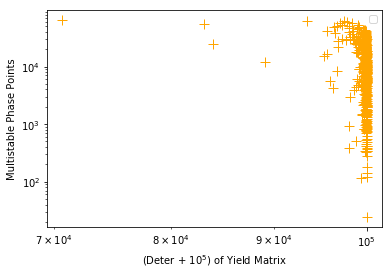

In [271]:
plt.xscale('log', basex=10)
plt.yscale('log', basey=10)
plt.plot(JJJData, Data[:,10], marker='+', linestyle='', color='orange', label='', markersize=10)
pylab.xlabel('(Deter + $10^5$) of Yield Matrix')
pylab.ylabel('Multistable Phase Points')
pylab.legend(loc='upper right')
plt.title('')
#pylab.xlim([95000,100000])

No handles with labels found to put in legend.


(95000, 100000)

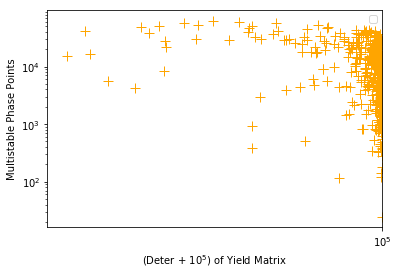

In [274]:
plt.xscale('log', basex=10)
plt.yscale('log', basey=10)
plt.plot(JJJData, Data[:,10], marker='+', linestyle='', color='orange', label='', markersize=10)
pylab.xlabel('(Deter + $10^5$) of Yield Matrix')
pylab.ylabel('Multistable Phase Points')
pylab.legend(loc='upper right')
plt.title('')
pylab.xlim([95000,100000])

No handles with labels found to put in legend.


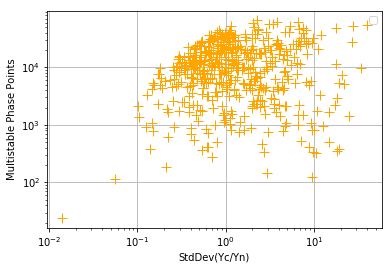

In [273]:
plt.xscale('log', basex=10)
plt.yscale('log', basey=10)
plt.plot(Data[:,8], Data[:,10], marker='+', linestyle='', color='orange', label='', markersize=10)
pylab.xlabel('StdDev(Yc/Yn)')
pylab.ylabel('Multistable Phase Points')
pylab.legend(loc='upper right')
plt.title('')
plt.grid(True)

In [111]:
Deter = np.zeros(shape=(TotalStates))
for S in range(TotalStates):
    Deter[S] = abs(np.linalg.det(I[S,:,:]))
    Deter[S] = 1/Deter[S]
    print('Deter ', S+1, Deter[S])

Deter  1 0.02499999999999999
Deter  2 1.0
Deter  3 0.05000000000000001
Deter  4 0.5
Deter  5 0.12500000000000003
Deter  6 0.0049999999999999975
Deter  7 inf


/home/pppandey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [112]:
TotalPoints = 10000
Data = np.zeros(shape=(TotalPoints,nC+nN+TotalStates))
VolFromMonte = np.zeros(shape=TotalStates)
StatePhase1 = 0; StatePhase3 = 0; StatePhase5 = 0; StatePhase7 = 0; StatePhase9 = 0
StatePhase11 = 0; StatePhase13 = 0
L1=[]
L3=[]
L5=[]
L7=[]
L9=[]
L11=[]
L13=[]
for PhiPoint in range(TotalPoints):#loop for chosing different Phi-points
    #print("PhiPoint:", PhiPoint)
    np.random.seed(PhiPoint)#This contains the seed
    Phi = np.random.uniform(10,1000,nC+nN)
    #print("Phi:", Phi)
    NoOfStates = 0; q = [0]*5
    for S in range(TotalStates):
        X = np.matmul(I[S,], Phi)
        for i in range(nC+nN):
            if (X[i] < 0.0):
                break
        if (X[i] > 0.0):
            #print(S+1)
            NoOfStates += 1
            q[NoOfStates] = S + 1
    if(NoOfStates == 1):
        StatePhase1 += 1
        L1.append(q[1])
        #print(PhiPoint,q)
    if(NoOfStates == 3):
        StatePhase3 += 1
        L3.append(q)
        #print(PhiPoint,q)
    if(NoOfStates == 5):
        StatePhase5 += 1
        L5.append(q)
        #print(PhiPoint,q)
    if(NoOfStates == 7):
        StatePhase7 += 1
        #print(PhiPoint,q)
        L7.append(q)
    if(NoOfStates == 9):
        StatePhase9 += 1
        #print(PhiPoint,q)
        L9.append(q)
    if(NoOfStates == 11):
        StatePhase11 += 1
        #print(PhiPoint,q)
        L11.append(q)
    if(NoOfStates == 13):
        StatePhase13 += 1
        #print(PhiPoint,q)
        L13.append(q)
print(StatePhase1,StatePhase3,StatePhase5,StatePhase7,StatePhase9,StatePhase11,StatePhase13)
#print(L1[1:])
Ratio = YieldC/YieldN
print("StdDev(Ratio) =", statistics.stdev(Ratio))
#print(L3[:])

10000 0 0 0 0 0 0
StdDev(Ratio) = 8.082903768654761
